# Portfolio management - ISF APP

# Imports

In [1]:
%pylab inline

import pandas as pd
import pandas_datareader as pdr
import scipy

Populating the interactive namespace from numpy and matplotlib


# 0. Data importation

In [2]:
data = pd.DataFrame()
TickerDax = ['DPW.DE','ALV.DE','BMW.DE','BAS.DE','FME.DE']
for x in TickerDax :
    data[x] = pdr.data.DataReader(name = x, data_source = 'yahoo',start = '2017-01-1',end = '2017-12-31')['Close']

data

,DPW.DE,ALV.DE,BMW.DE,BAS.DE,FME.DE
Date,,,,,
2017-01-02,31.400000,157.300003,89.980003,88.699997,82.199997
2017-01-03,31.500000,159.550003,90.830002,87.699997,81.260002
2017-01-04,31.325001,160.399994,90.180000,88.150002,80.870003
2017-01-05,31.855000,160.699997,90.339996,87.790001,80.540001
2017-01-06,31.870001,161.100006,90.510002,87.519997,80.599998
...,...,...,...,...,...
2017-12-21,40.705002,196.250000,87.839996,93.690002,87.410004
2017-12-22,40.494999,195.250000,87.519997,93.510002,88.230003
2017-12-27,40.610001,194.100006,87.260002,93.589996,88.389999


# 1. Values of interest

### Returns

In [3]:
## Daily Returns
daily_returns = pd.DataFrame( (data.values / data.shift(1).values - ones(data.shape))[1:,:] ) 
daily_returns.columns = data.columns
daily_returns

,DPW.DE,ALV.DE,BMW.DE,BAS.DE,FME.DE
0,0.003185,0.014304,0.009447,-0.011274,-0.011435
1,-0.005556,0.005327,-0.007156,0.005131,-0.004799
2,0.016919,0.001870,0.001774,-0.004084,-0.004081
3,0.000471,0.002489,0.001882,-0.003076,0.000745
4,-0.008001,-0.004966,-0.007513,0.001600,-0.068114
...,...,...,...,...,...
249,-0.001961,0.004607,0.010468,0.006013,-0.000343
250,-0.005159,-0.005096,-0.003643,-0.001921,0.009381
251,0.002840,-0.005890,-0.002971,0.000855,0.001813
252,-0.011697,-0.004379,-0.001375,-0.008655,-0.002489


In [4]:
n_days = daily_returns.shape[0]
mean_returns = n_days * daily_returns.mean().values
print(mean_returns)

[ 0.2479976   0.20499064 -0.02391942  0.04486442  0.08014268]


### Variance/covariance

In [5]:
## Marginal variances
var_covar = n_days * daily_returns.cov()

var_covar

,DPW.DE,ALV.DE,BMW.DE,BAS.DE,FME.DE
DPW.DE,0.024376,0.011194,0.009907,0.012387,0.009991
ALV.DE,0.011194,0.016499,0.009791,0.011556,0.007837
BMW.DE,0.009907,0.009791,0.023518,0.011885,0.007562
BAS.DE,0.012387,0.011556,0.011885,0.022493,0.010644
FME.DE,0.009991,0.007837,0.007562,0.010644,0.028850


In [6]:
inv_var_covar = pd.DataFrame(inv(var_covar))
inv_var_covar

,0,1,2,3,4
0,67.567653,-26.714440,-6.509130,-16.008987,-8.528979
1,-26.714440,114.599247,-18.697315,-31.806937,-5.241527
2,-6.509130,-18.697315,63.521721,-19.340425,-2.181622
3,-16.008987,-31.806937,-19.340425,85.686212,-12.361422
4,-8.528979,-5.241527,-2.181622,-12.361422,44.171792


In [7]:
tmp_var_covar = var_covar.values
marginal_variances = pd.DataFrame([ tmp_var_covar[i, i] for i in range(len(tmp_var_covar)) ]).transpose()
marginal_variances.columns = var_covar.columns
del tmp_var_covar

marginal_variances

,DPW.DE,ALV.DE,BMW.DE,BAS.DE,FME.DE
0,0.024376,0.016499,0.023518,0.022493,0.02885


In [8]:
tmp_marginal_variances = marginal_variances.values
standard_deviations = pd.DataFrame( sqrt(tmp_marginal_variances) )
standard_deviations.columns = marginal_variances.columns
del tmp_marginal_variances

standard_deviations

,DPW.DE,ALV.DE,BMW.DE,BAS.DE,FME.DE
0,0.156128,0.128447,0.153356,0.149975,0.169853


# 2. Markowitz framework parameters

In [13]:
ones_d = ones(data.shape[1])

# Params of the best portfolio
a = ones_d.T.dot(inv_var_covar).dot(ones_d) #1d' S-1 1d
b = mean_returns.T.dot(inv_var_covar).dot(ones_d) #R' S-1 1d

# Mean/sd of the best portfolio (a,b)
sd_star = 1/sqrt(a)
mean_star = b/a

print('Expected return of the minimum variance portfolio in %')
print(100 * mean_star)
print('Its standard deviation in %')
print(100 * sd_star)

Expected return of the minimum variance portfolio in %
12.587219585783954
Its standard deviation in %
11.12726048763086


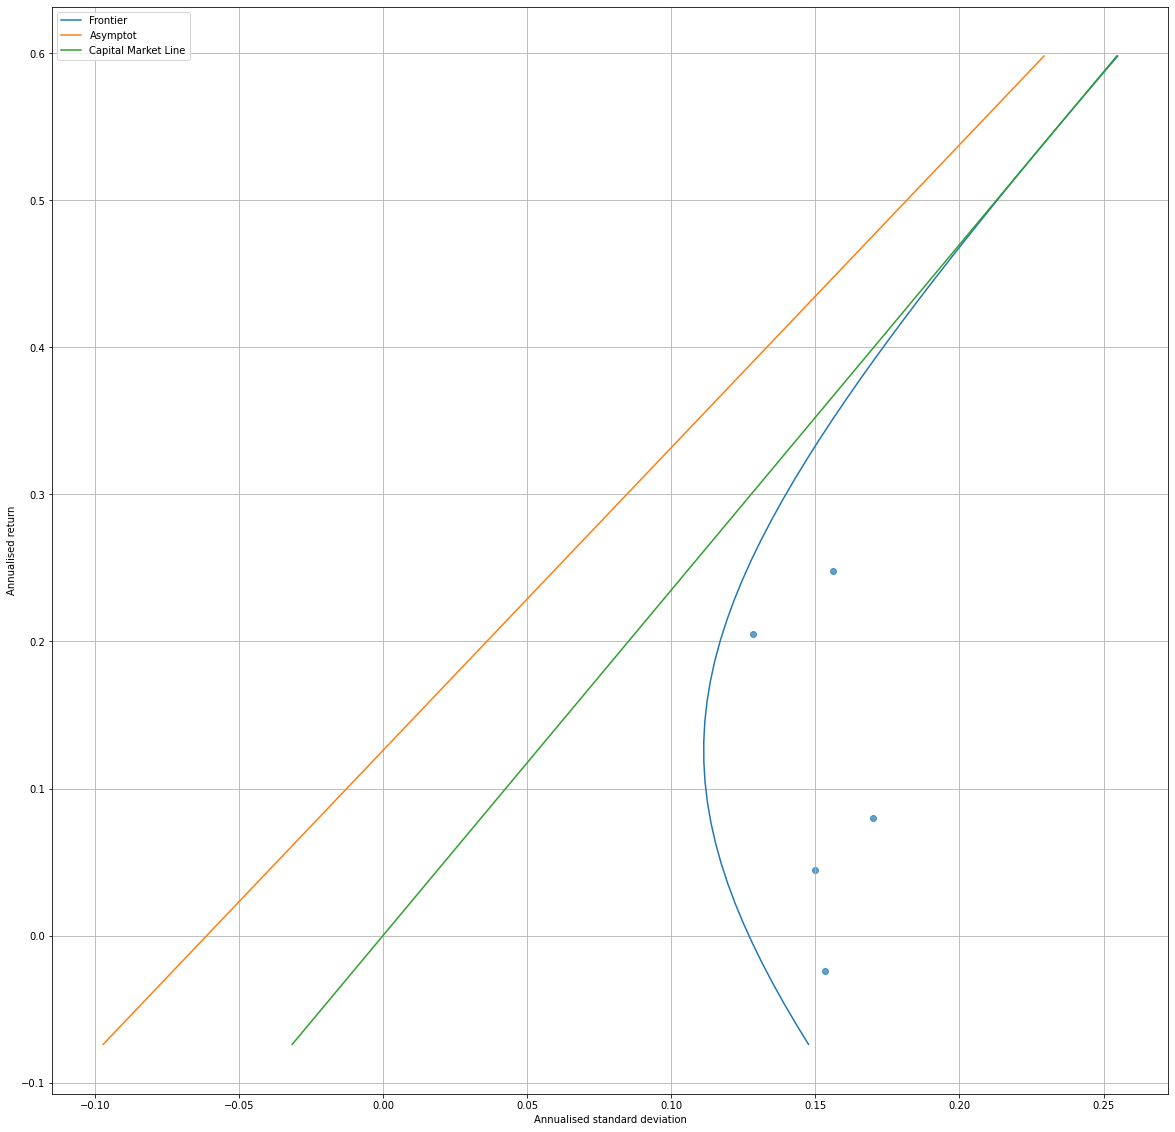

In [14]:
figure(figsize = (20, 20) )

#asset values
scatter(standard_deviations, mean_returns, alpha=0.7) 

#x
lower_bound = min(mean_returns) - 0.05
upper_bound = max(mean_returns) + 0.35
x = linspace(lower_bound , upper_bound, 50)

#Efficient frontier
m_w = sqrt( (mean_returns - b/a).T.dot( (inv_var_covar) ).dot( (mean_returns - b/a) ) )
frontier = sqrt( ((x - mean_star)/m_w)**2 + sd_star**2 )

#Asymptotic line of the frontier
a_line = (x - b/a)/m_w

#Capital market line
r0 = 0 # risk free rate
m_r = sqrt( (mean_returns - r0).T.dot( (inv_var_covar) ).dot( (mean_returns - r0) ) )
CML = (x - r0)/m_r

#Plot
plot(frontier, x, alpha=1) 
plot(a_line, x, alpha=1)  # on graph l'Asymptote
plot(CML, x, alpha=1) # on graph la Capital Market Line 
legend(['Frontier','Asymptot','Capital Market Line' ], loc=2)
grid(True)
xlabel('Annualised standard deviation')
ylabel('Annualised return')
show()

# 3. Exercise

## 3.1 Markowitz & optimal allocations

q.1 According to the Markowitz theory **without** a risk-free asset, if we want an annual return of 15%, what is the optimal allocation ?

q.2 According to the Markowitz theory **with** a risk-free asset (with 0-return), if we want an annual return of 15%, what is the optimal allocation ?

**q.1**

Let's recall that the problem to solve is :

$$(P) \left \{
  \begin{array}{l1}
    min_{\pi \in \mathbf{R}^{d}} ||\pi||_{\Sigma^{-1}} \\
    <\pi,M> = m \\
    <pi, 1_d> = 1 
  \end{array}
  \right.
$$

That is to say the **investment** portfolio with **fixed return**, of **min variance**.

The solutions are given by :

$$ \mathbf{F} := \{ \pi_a + \lambda \omega_{a,b} \} $$

With :

M the expected return of the assets

$$ 

a := <1_{d}, 1_{d}>_{\Sigma^{-1}} \\
b := <M, 1_{d}>_{\Sigma^{-1}} \\
\pi_a := \frac{1}{a} \Sigma^{-1} 1_{d} \\
\omega_{a,b} := \frac {\Sigma^{-1}(M - \frac{b}{a} 1_d)} {||M - \frac{b}{a} 1_d||_{\Sigma^{-1}} }

$$

So at least we have computed all of theprevious quantities, we have an estimation of M so the only uknown is $\lambda$ and we have to resolve :

$$ 
\pi'M = 15\%, \pi \in \mathbf{F} \\
\Leftrightarrow \\
(\pi_a + \lambda \omega_{a,b})'M = 15\% \\
\Leftrightarrow \\
\lambda = (\omega_{a,b}'M)^{-1}(15\% - \pi_{a}'M)
$$

And we get the alocation by the relation :
$$ \{ \pi_a + \lambda \omega_{a,b} \} $$



In [44]:
def markowitz_woRiskFreeAsset(wanted_return, expected_returns = mean_returns, a = a, b = b, inv_var_covar = inv_var_covar):
  ones_d = ones(inv_var_covar.shape[0])
  pi_a = 1/a * inv_var_covar.dot(ones_d)
  tmp = expected_returns - b/a*ones_d
  omega_a_b = inv_var_covar.dot( tmp / (tmp.T.dot(inv_var_covar).dot(tmp))**(1/2) )
  Lambda = 1/(omega_a_b.T.dot(expected_returns)) * (wanted_return - pi_a.T.dot(expected_returns))
  output = pi_a + Lambda * omega_a_b
  assert round(output.T.dot(expected_returns), 3) == round(wanted_return, 3), "Problem: the computed output has a return <> of the wanted one, its return :" + str(output.T.dot(expected_returns))
  assert round(output.dot(ones_d), 1) == 1, 'Your potfolio is not an investment portfolio'
  print("lambda value (argmax):")
  print(Lambda)
  print("best alocation:")
  print(output)
  #return output, Lambda

In [47]:
markowitz_woRiskFreeAsset(15/100)

lambda value (argmax):
0.011721724539916791
best alocation:
0    0.171528
1    0.462973
2    0.150282
3    0.031100
4    0.184118
dtype: float64


**q.2**

The new problem to solve is :

$$
(Q) \left \{
  \begin{array}{l1}
    min_{\pi \in \mathbf{R}^{d}} ||\pi||_{\Sigma^{-1}} \\
    r_{0}  + \pi'(M-r_{0}1_{d}) = m
  \end{array}
  \right.
$$

According to the separation theorem, the solutions are given by

$$
\beta \Pi_{T} + (1 - \beta) \Pi_{0} \\
\beta = \frac{ m - r_{0} }{ m_{T} - r_{0} } \\
\Pi_{0} = \begin{bmatrix} 1 \\ 0 \end{bmatrix} \\
\Pi_{T} = \begin{bmatrix} 0 \\ \pi_{T} \end{bmatrix} \\
\pi_{T} = \frac{1}{b-r_{0}a} \Sigma^{-1} (M - r_{0} 1_{d} ) \\
m_{T} = r_{0} + \frac{1}{b-r_{0}a} || M - r_{0}1_{d} ||^{2}_{\Sigma^{-1}}
$$

With the same notations as before except for $r_{0}$ risk-free asset return and $m_{T}$ : the return of the risky part of the portfolio.

In [68]:
def markowitz_withRiskFreeAsset(wanted_return, r0 = 0, expected_returns = mean_returns,a = a, b = b, inv_var_covar = inv_var_covar):
  ones_d = ones(inv_var_covar.shape[0])
  tmp = mean_returns - r0*ones_d
  coeff = 1/(b - r0*a)
  m_T = r0 +  coeff * tmp.T.dot(inv_var_covar).dot(tmp)
  pi_T = coeff * inv_var_covar.dot(tmp)
  beta = (wanted_return - r0)/(m_T - r0)
  output = zeros( pi_T.shape[0] + 1)
  output[0] = 1 - beta
  output[1:] = beta * pi_T
  assert round(sum(pi_T), 0) == 1, "The risky allocation is not an investment allocation"
  assert round((1-beta)*r0 + beta*pi_T.T.dot(tmp), 3) == round(wanted_return, 3), "The allocation does not have the wanted return"
  print("Allocation :")
  print(output)
  #return output

In [69]:
markowitz_withRiskFreeAsset(15/100)

Allocation :
[ 0.72357614  0.27284164  0.42055532 -0.21777025 -0.19507013 -0.00413271]


28% in the risk-free asset, 72% * (27%, 42%, -21%, -19%, -0.4%) in the risky assets.

## 3.2. Markowitz under constraints